## Multi Pendulum Cart Problem

In [1]:
%matplotlib inline
import sympy
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from sympy import Matrix, MatrixSymbol, Symbol, symbols, cos, sin, BlockMatrix
from scipy.linalg import solve_continuous_are
from scipy.signal import place_poles, step, lti
from scipy import signal
from tqdm import tqdm
import code.dynamics as dy
from code.utils import plot_respone
from code.controller import lqr, lqg

## Declare the symbols

In [2]:
x, theta1, theta2, u = (dy.x, dy.theta1, dy.theta2, dy.u)
x_dot, theta1_dot, theta2_dot = (dy.x_dot, dy.theta1_dot, dy. theta2_dot)
x_ddot, theta1_ddot, theta2_ddot = (dy.x_ddot, dy.theta1_ddot, dy. theta2_ddot)
state = Matrix([x,x_dot, theta1, theta1_dot, theta2, theta2_dot])

# variables
m1, m2, M = (dy.m1, dy.m2, dy.M)
l1, l2 = (dy.l1, dy.l2)
g = dy.g

variables = dy.variables

# ## 
# x_ddot = (u-(g/2)*(m1*sin(2*theta1)+m2*sin(2*theta2))-(m1*l1*(theta1_dot**2)*sin(theta1))-(m2*l2*(theta2_dot**2)*sin(theta2))
#          )/(M+m1*((sin(theta1))**2)+m2*((sin(theta2))**2))
# x_ddot = x_ddot.subs(variables)
# theta1_ddot = x_ddot*cos(theta1)/l1 - g*sin(theta1)/l1
# theta2_ddot = x_ddot*cos(theta2)/l2 - g*sin(theta2)/l2
# theta1_ddot =  theta1_ddot.subs(variables)
# theta2_ddot = theta2_ddot.subs(variables)

In [3]:
state

Matrix([
[             x],
[       \dot{x}],
[      \theta_1],
[\dot{\theta_1}],
[      \theta_2],
[\dot{\theta_2}]])

In [4]:

N = dy.N #number of tate
R = Matrix([.003])
Q = sympy.eye(N,N)*150

A_sub = dy.A.subs(variables)
B_sub = dy.B.subs(variables)
A_arr = np.array(A_sub,dtype=np.float32)
B_arr = np.array(B_sub,dtype=np.float32)
Q_arr = np.array(Q,dtype=np.float32)
R_arr = np.array(R,dtype=np.float32)

In [5]:
print(sympy.latex(dy.C))

\left[\begin{matrix}1 & 0 & 0 & 0 & 0 & 0\\0 & 1 & 0 & 0 & 0 & 0\\0 & 0 & 1 & 0 & 0 & 0\\0 & 0 & 0 & 1 & 0 & 0\\0 & 0 & 0 & 0 & 1 & 0\\0 & 0 & 0 & 0 & 0 & 1\end{matrix}\right]


## LQR 
Solves the continuous algebraic Riccati equation, or CARE, defined as 
$$(A^TP + PA - PBR^{-1}B^TP+Q=0)$$
directly using a Schur decomposition method.

Then compute $K = -R^{-1}B^TP$ the optimal solution to LQR Control problem

In [6]:
K = lqr(A_arr,B_arr,Q_arr,R_arr)

### Defining State Space equation
$$
\dot x  = Ax+BKu
$$
$$
Y = Cx
$$
Calculating next state, for given $\delta t$ (dt) time interval.

## Running LQR Controller
* Running for total time = $1000$ sec, and $dt = 0.01$ sec. 
* Initial Condition is defined as 
$$ X(0) = [0,0,30,0,40,0]$$

In [11]:
def state_space(A,B,C,K,X_states,ue_controller=True):
    total_time = 500
    dt = .01

    Ts = np.arange(0,total_time,dt)

    curr_state = state.subs(X_states)
    output = []
    non_linear_outputs = []
    # print("\ncurrent_states: ",X_states)
    if ue_controller:
        optimal_control_input = K
        A_new = A + B*optimal_control_input
    else:
        # Take initial condition here input u i 0.
        optimal_control_input = 0
        A_new = A

    for i in tqdm(Ts):
        u_temp = (optimal_control_input*curr_state)[0]
        X_states = {x:curr_state[0],x_dot:curr_state[1], theta1:curr_state[2], theta1_dot:curr_state[3], theta2: curr_state[4], theta2_dot:curr_state[5], u:u_temp}
        next_state,Y = dy.state_space_model(A_new,B,C,curr_state,0,dt)
        non_linear_output = dy.non_linear_state_space_model(X_states)
        curr_state=next_state
        # print(curr_state)
        # print(X_states)
        # print("#######")
        output.append(Y)
        non_linear_outputs.append(non_linear_output)
        # print(non_linear_output)
    output_arr = np.array(output,dtype=np.float32).squeeze()
    # print(non_linear_outputs)
    non_linear_output_arr = np.array(non_linear_outputs,dtype=np.float32).squeeze()

    return output_arr, non_linear_output_arr, Ts

In [8]:
x_states = {x:0,x_dot:0, theta1: math.radians(30), theta1_dot:0, theta2:math.radians(40), theta2_dot:0, u:0}

# x_states = {x:0,x_dot:0, theta1: 30, theta1_dot:0, theta2 : 40, theta2_dot:0, u:0}
%timeit non_linear_state_space_model(x_states)

NameError: name 'non_linear_state_space_model' is not defined

In [12]:
def state_space_observer(A,B,C,L,K,X_states):
    total_time = 500
    dt = .01

    Ts = np.arange(0,total_time,dt)
    states = Matrix(BlockMatrix([[state],[sympy.zeros(*state.shape)]])) # state with state estimates
    curr_state = states.subs(X_states)
    output = []
    
    A_block = Matrix(BlockMatrix([[A+B*K,-B*K],[sympy.zeros(*A.shape),A-L*C]]))
    B_block = Matrix(BlockMatrix([[B],[sympy.zeros(*B.shape)]]))
    C_block = Matrix(BlockMatrix([C,sympy.zeros(*C.shape)]))
    D_block = sympy.zeros(C.shape[0],1)
    optimal_control_input = Matrix(BlockMatrix([K,sympy.zeros(*K.shape)]))
    
    A_block_arr = np.array(A_block,dtype=np.float32)
    B_block_arr = np.array(B_block,dtype=np.float32)
    C_block_arr = np.array(C_block,dtype=np.float32)
    D_block_arr = np.array(D_block,dtype=np.float32)
    inp = 0
    non_linear_outputs = []
    all_states = []
    for i in tqdm(Ts):
        u_temp = (optimal_control_input*curr_state)[0]
        X_states = {x:curr_state[0],x_dot:curr_state[1], theta1:curr_state[2], theta1_dot:curr_state[3], theta2: curr_state[4], theta2_dot:curr_state[5], u:u_temp}
        all_states.append(curr_state)
        
        next_state,Y = dy.state_space_model(A_block,B_block,C_block,curr_state,0,dt)    
        non_linear_output = dy.non_linear_state_space_model(X_states)
        curr_state=next_state
        
        output.append(Y)
        non_linear_outputs.append(non_linear_output)
        # print(non_linear_output)
    output_arr = np.array(output,dtype=np.float32).squeeze()
    # print(non_linear_outputs)
    non_linear_output_arr = np.array(non_linear_outputs,dtype=np.float32).squeeze()
    output_arr = np.array(output,dtype=np.float32).squeeze()
    all_states_arr = np.array(all_states,dtype=np.float32)
    return output_arr, non_linear_output_arr, all_states_arr, Ts, (A_block_arr,B_block_arr,C_block_arr,D_block_arr)

### Running state space system and plotting without LQR controller

plot_respone(output_arr_wo_control,time_steps,N, plot_title="Response Without Controller")

### Running state space system and plotting with LQR controller


In [ ]:
# Running state space with LQR controller
X_states = {x:0,x_dot:0, theta1:30, theta1_dot:0, theta2:40, theta2_dot:0, u:0}
output_arr, non_linear_output_arr, time_steps = state_space(A_sub,B_sub,dy.C,K,X_states,True)

In [ ]:
plot_respone(output_arr,time_steps,N,state,save=True)

In [ ]:
# Non linear plotting
plot_respone(non_linear_output_arr,time_steps,N,state=[x_dot,x_ddot,theta1_dot,theta1_ddot,theta2_dot,theta2_ddot],plot_title="Non Linear Controller Response", Plot_filename="Non Linear Controller Response",save=True)

## Observability of state space

In [9]:
C1 = (Matrix([[1,0,0,0,0,0]]),x)
C2 = (Matrix([[0,0,1,0,0,0],[0,0,0,0,1,0]]),(theta1,theta2))
C3 = (Matrix([[1,0,0,0,0,0],[0,0,0,0,1,0]]),(x,theta2))
C4 = (Matrix([[1,0,0,0,0,0],[0,0,1,0,0,0],[0,0,0,0,1,0]]),(x,theta1,theta2))
Cs_temp = [C1,C2,C3,C4]
Cs = []
for c,st in Cs_temp:
    
    observer =  Matrix(BlockMatrix([[c*dy.A**i] for i in range(N)]))
    rk = observer.rank()
    if rk==N:
        # sympy.pprint(st)
        print(f"{st} is observable")
        Cs.append((c,st))
    else:
        print(f"{st} is not observable")

x is observable
(\theta_1, \theta_2) is not observable
(x, \theta_2) is observable
(x, \theta_1, \theta_2) is observable


## Luenberger Observer

In [ ]:
# Find the L for above given output vector
# Fixing eigen values for the A-L, we can reversely find L
Ls = []
eig = np.array(Matrix([-1,-1.5,-2, -2.5, -3,-3.5]),dtype=np.float32).reshape(-1,)
for c, st in Cs:
    C_arr = np.array(c.T,dtype=np.float32)
    print(C_arr.shape,A_arr.shape)
    out = place_poles(A_arr,C_arr,eig)
    O = np.round_(out.gain_matrix,3)
    L = Matrix(O).T
    Ls.append(L)
    print(L)
    # print(sympy.latex(L))

In [ ]:
all_step_output = []
all_output_arr_control_observe = []
all_output_arr_control_observe_non_linear = []
all_sys = []
X_states = {x:0,x_dot:0, theta1:30, theta1_dot:0, theta2:40, theta2_dot:0, u:0}
for c, l in zip(Cs,Ls):
    output_arr_control_observe, non_linear_output_arr_control_observe , time_steps, sys = state_space_observer(A_sub,B_sub,c[0],l,K,X_states)
    all_output_arr_control_observe.append(output_arr_control_observe)
    all_output_arr_control_observe_non_linear.append(non_linear_output_arr_control_observe)
    t, Y = signal.step2(sys,T=time_steps)
    all_step_output.append(Y)
    all_sys.append(sys)

In [ ]:
plot_respone(all_output_arr_control_observe[2],time_steps,N,Cs[2][1],plot_title=f"${Cs[2][1]}$ Controller Oberver Response",Plot_filename="x_theta1_theta2_Controller+OberverResponse", save=True)

In [ ]:
plot_respone(all_output_arr_control_observe[2],time_steps,N,Cs[2][1],plot_title=f"${Cs[2][1]}$ Controller Oberver Response",Plot_filename="x_theta1_theta2_Controller+OberverResponse-non-linear", save=False)

In [ ]:
plot_respone(all_step_output[2],time_steps,N,Cs[2][1], plot_title=f"${Cs[2][1]}$ Step Response", Plot_filename ="x_theta1_theta2_Controller+OberverStepResponse",save=True)

## LQG Controller

In [13]:
# zero mean covariance matrix for state and for output
BdCov_ubBd = 0.3*np.identity(N) # Process noise covariance
cov_vd = np.array([1]).reshape(1,1) # measurement noise covariance

X_states = {x:0,x_dot:0, theta1:30, theta1_dot:0, theta2:40, theta2_dot:0, u:0}
for c in Cs:
    C_arr = np.array(c[0],dtype=np.float32)
    optimal_L = lqg(A_arr.T,C_arr.T,BdCov_ubBd,cov_vd)
    output_arr_control_observe, non_linear_output_arr_control_observe, all_states, time_steps, sys = state_space_observer(A_sub,B_sub,c[0],optimal_L,K,X_states)
    break

100%|██████████| 50000/50000 [03:56<00:00, 211.65it/s]


In [44]:
output_arr_control_observe.shape

(50000,)

6


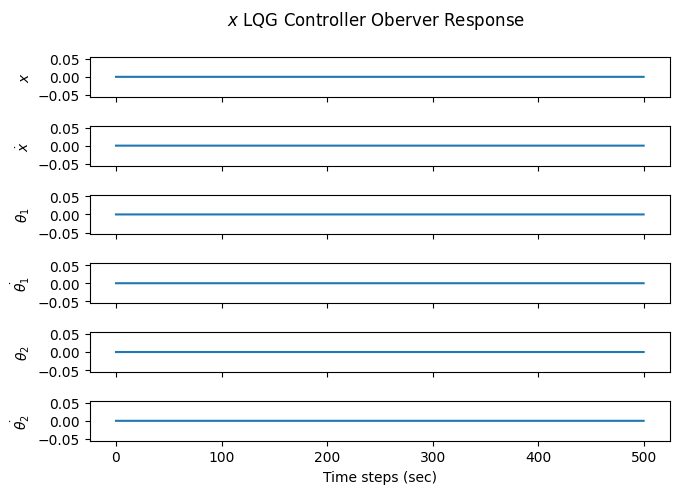

In [15]:
plot_respone(all_states[:,6:],time_steps,N,state,plot_title=f"${Cs[0][1]}$ LQG Controller Oberver Response",Plot_filename="x_LQG_Controller+OberverResponse", save=False)

6


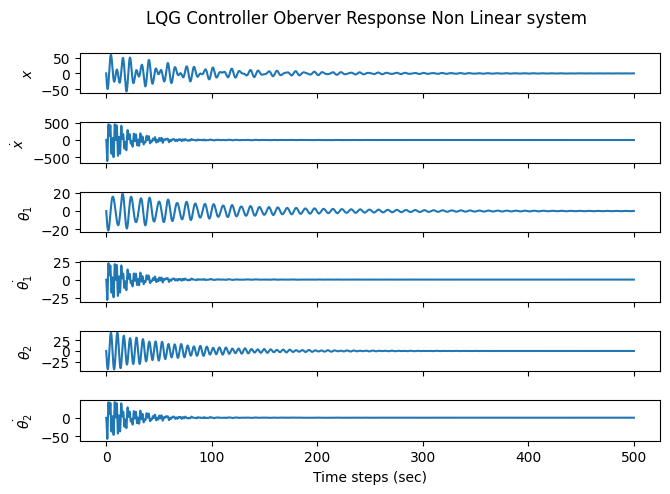

In [39]:
plot_respone(non_linear_output_arr_control_observe,time_steps,N,state,plot_title=f"LQG Controller Oberver Response Non Linear system",Plot_filename="non_linear_LQG_Controller+OberverResponse", save=False)

## Printing $P$

In [ ]:

P_round = np.round(P,2)
P_sub = Matrix(P_round)
print(sympy.latex(K))

In [ ]:
print(sympy.latex(P_sub.det()))

In [ ]:
print(P)

In [ ]:
EIG = np.linalg.eigvals(A_arr+B_arr@K_arr)
EIG = np.round(EIG,3)
EIG_sy = Matrix(EIG)